# Import

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import ConcatDataset, DataLoader
import torch.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from google.colab import files

Flemme de tout expliquer mais en gros: rsample -> permet de faire la backpropagation tandis que sample non. Car utilisation du reparameterization trick

On commence par MNIST. Donc Binary donc pas laplace mais bernoulli plutot pour la reconstruction. Et pour la fin du classifier vu qu'il n'y a qu'un label possible mettre un softmax et non un sigmoid.

# Import the data

## CelebA

In [ ]:
%pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=ae79e2145ec06a8accf4700828d170bb9fe3c790178a61c29520a8620c54c319
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import os
import wget
import zipfile

data_root = "datasets"

base_url = "https://graal.ift.ulaval.ca/public/celeba/"

file_list = [
    "img_align_celeba.zip",
    "list_attr_celeba.txt",
    "identity_CelebA.txt",
    "list_bbox_celeba.txt",
    "list_landmarks_align_celeba.txt",
    "list_eval_partition.txt",
]

# Path to folder with the dataset
dataset_folder = f"{data_root}/celeba"
os.makedirs(dataset_folder, exist_ok=True)

for file in file_list:
    url = f"{base_url}/{file}"
    if not os.path.exists(f"{dataset_folder}/{file}"):
        wget.download(url, f"{dataset_folder}/{file}")

with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as ziphandler:
    ziphandler.extractall(dataset_folder)

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((64, 64), antialias=True),
    ]
)

train_dataset = datasets.CelebA(data_root, split="train", target_type=["attr"], transform=transform)
valid_dataset = datasets.CelebA(data_root, split="valid", target_type=["attr"], transform=transform)
test_dataset = datasets.CelebA(data_root, split="test", target_type=["attr"], transform=transform)

# Spécifiez les attributs que vous souhaitez conserver
selected_attributes = [
    'Arched_Eyebrows', 'Bags_Under_Eyes', 'Bangs', 'Black_Hair',
    'Blond_Hair', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Eyeglasses',
    'Heavy_Makeup', 'Male', 'No_Beard', 'Pale_Skin', 'Receding_Hairline',
    'Smiling', 'Wavy_Hair', 'Wearing_Necktie', 'Young'
]

# Sélectionnez les indices des attributs spécifiés
selected_indices = [train_dataset.attr_names.index(attr) for attr in selected_attributes]

# Créez une fonction pour retourner les exemples d'attributs sélectionnés
def select_attributes(example):
    return example.attr[selected_indices]

# Appliquez la fonction de sélection des attributs au dataset
train_dataset.attr = train_dataset.attr[:, selected_indices]
valid_dataset.attr = valid_dataset.attr[:, selected_indices]
test_dataset.attr = test_dataset.attr[:, selected_indices]
train_dataset = ConcatDataset([train_dataset, valid_dataset])


# Créez le DataLoader avec le dataset modifié
batch_size = 256  # Choisissez la taille de lot appropriée
celeba_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
celeba_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Chest X-Ray

In [ ]:
url = "https://www.dropbox.com/scl/fi/szdjcksp3d2ai8wsmnf3b/chest.zip?rlkey=v3ylax39i1m64d985o8yc3dpn&dl=0"
path_file_zip = "chest.zip?rlkey=v3ylax39i1m64d985o8yc3dpn"
!wget $url
!unzip $path_file_zip -d /content/datasets

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/datasets/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/datasets/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/datasets/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/datasets/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/datasets/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/datasets/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/datasets/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/datasets/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/datasets/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/datasets/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/datasets/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: /content/datasets/chest_xray/train/NORMAL/IM-0442-0001.jpeg

In [ ]:
# Chemin vers le dossier contenant les données
train_dir = '/content/datasets/chest_xray/chest_xray/train'
test_dir = '/content/datasets/chest_xray/chest_xray/test'
val_dir = '/content/datasets/chest_xray/chest_xray/val'

# Transformation pour redimensionner les images et les convertir en tenseurs
# Image de trop grande qualité, que fait on ?
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

def one_hot_transform(target):
    return F.one_hot(torch.tensor(target), num_classes=3)

# Création des datasets train et test à partir des dossiers
train_set = datasets.ImageFolder(root=train_dir, transform=transform)
test_set = datasets.ImageFolder(root=test_dir, transform=transform)
val_set = datasets.ImageFolder(root=val_dir, transform=transform)


# Remplacer les étiquettes 'normal' par 0 et 'pneumonia' par 1 dans le train set
class_to_idx = train_set.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

for idx, (image, label) in enumerate(train_set.imgs):
    folder_name = idx_to_class[label]
    if folder_name == 'NORMAL':
        train_set.imgs[idx] = (image, 0)
    else:
        # Vous devrez obtenir les sous-dossiers pour 'pneumonia'
        filename = train_set.imgs[idx][0].split('/')[-1]  # Récupère le nom du fichier
        category = filename.split('_')[1]  # La deuxième partie dans le nom du fichier
        if category == 'bacteria':
            train_set.imgs[idx] = (image, 1)
        elif category == 'virus':
            train_set.imgs[idx] = (image, 2)

# Faites de même pour le test_set
for idx, (image, label) in enumerate(test_set.imgs):
    folder_name = idx_to_class[label]
    if folder_name == 'NORMAL':
        test_set.imgs[idx] = (image, 0)
    else:
        # Obtenez les sous-dossiers pour 'pneumonia'
        filename = test_set.imgs[idx][0].split('/')[-1]  # Récupère le nom du fichier
        category = filename.split('_')[1]  # La deuxième partie dans le nom du fichier
        if category == 'bacteria':
            test_set.imgs[idx] = (image, 1)
        elif category == 'virus':
            test_set.imgs[idx] = (image, 2)

# Faites de même pour le val_set
for idx, (image, label) in enumerate(val_set.imgs):
    folder_name = idx_to_class[label]
    if folder_name == 'normal':
        val_set.imgs[idx] = (image, 0)
    elif folder_name == 'pneumonia':
        # Obtenez les sous-dossiers pour 'pneumonia'
        filename = val_set.imgs[idx][0].split('/')[-1]  # Récupère le nom du fichier
        category = filename.split('_')[1]  # La deuxième partie dans le nom du fichier
        if category == 'bacteria':
            val_set.imgs[idx] = (image, 1)
        elif category == 'virus':
            val_set.imgs[idx] = (image, 2)


train_set.target_transform = one_hot_transform
test_set.target_transform = one_hot_transform
val_set.target_transform = one_hot_transform

batch_size = 128

train_dataset = ConcatDataset([train_set, val_set])

# Création des DataLoader pour itérer sur les datasets
chest_train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
chest_test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

## MNIST

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

data_root = "datasets"

def one_hot_transform(target):
    return F.one_hot(torch.tensor(target), num_classes=10)
train_dataset = MNIST(root=data_root, train=True, download=True, transform=transform, target_transform=one_hot_transform)
test_dataset = MNIST(root=data_root, train=False, download=True, transform=transform, target_transform=one_hot_transform)
batch_size = 128
mnist_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
mnist_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 105523716.72it/s]


Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 37902282.17it/s]


Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31070788.22it/s]


Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7029715.41it/s]


Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw



# CCVAE network

In [ ]:
class Classifier(nn.Module):
  def __init__(self, n_zc_per_label, device):
    super(Classifier, self).__init__()
    block_diag_matrices = [torch.ones(1, n_zc) for n_zc in n_zc_per_label]
    self.mask = torch.block_diag(*block_diag_matrices).float().to(device)
    self.classifier = nn.Linear(np.sum(n_zc_per_label), len(n_zc_per_label)).to(device)

    with torch.no_grad():
      # Initialize with 0 and 1
      self.classifier.weight /= self.classifier.weight
      self.classifier.weight *= self.mask
      self.classifier.bias *= torch.zeros_like(self.classifier.bias, device=device).float()

  def forward(self, zc):
    return self.classifier(zc)

  def zeros_grad(self):
    with torch.no_grad():
      self.classifier.weight.grad *= self.mask

class CondPrior(nn.Module):
    def __init__(self, n_zc_per_label, device):
        super(CondPrior, self).__init__()
        block_diag_matrices = [torch.ones(n_zc, 1) for n_zc in n_zc_per_label]
        self.mask = torch.block_diag(*block_diag_matrices).float().to(device)
        self.predict_mean_true = nn.Linear(len(n_zc_per_label), np.sum(n_zc_per_label), bias=False).to(device)
        self.predict_mean_false = nn.Linear(len(n_zc_per_label), np.sum(n_zc_per_label), bias=False).to(device)
        self.predict_log_var_true = nn.Linear(len(n_zc_per_label), np.sum(n_zc_per_label), bias=False).to(device)
        self.predict_log_var_false = nn.Linear(len(n_zc_per_label), np.sum(n_zc_per_label), bias=False).to(device)

        with torch.no_grad():
          # Initialize with mu=0 and std=1
          self.predict_mean_true.weight *= torch.zeros_like(self.mask, device=device).float()
          self.predict_mean_false.weight *= torch.zeros_like(self.mask, device=device).float()
          self.predict_log_var_true.weight *= torch.zeros_like(self.mask, device=device).float()
          self.predict_log_var_false.weight *= torch.zeros_like(self.mask, device=device).float()

    def forward(self, y):
        mu = self.predict_mean_true(y) + self.predict_mean_false(1-y)
        log_var = self.predict_log_var_true(y) + self.predict_log_var_false(1-y)
        return mu, log_var

    def zeros_grad(self):
      with torch.no_grad():
        self.predict_mean_true.weight.grad *= self.mask
        self.predict_mean_false.weight.grad *= self.mask
        self.predict_log_var_true.weight.grad *= self.mask
        self.predict_log_var_false.weight.grad *= self.mask

In [ ]:
class CCVAEencoder(nn.Module):
  def __init__(self, latent_dim, n_channels):
    super(CCVAEencoder, self).__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels=n_channels, out_channels=32, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=1, padding=0),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Flatten()
    )

    self.meansEncoder = nn.LazyLinear(out_features=latent_dim)
    self.stdsEncoder = nn.LazyLinear(out_features=latent_dim)

  def forward(self, x):
    '''
    Return mu and std such as q(z|x) ~ N(mu, std)
    '''
    encoded = self.encoder(x)
    mu = self.meansEncoder(encoded)
    log_var = self.stdsEncoder(encoded) # so that std = torch.exp(log_var/2)
    return mu, log_var

class View(nn.Module):
  def __init__(self, size):
    super(View, self).__init__()
    self.size = size

  def forward(self, tensor):
    return tensor.view(self.size)

class CCVAEdecoder(nn.Module):
  def __init__(self, latent_dim, n_channels):
    super(CCVAEdecoder, self).__init__()

    self.decoder = nn.Sequential(
        nn.Linear(in_features=latent_dim, out_features=256),
        View((-1, 256, 1, 1)),
        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=1, padding=0),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=32, out_channels=n_channels, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(n_channels),
        nn.Sigmoid()
    )

  def forward(self, z):
    '''
    Return the image
    '''
    decoded = self.decoder(z)
    return decoded

In [ ]:
class CCVAE(nn.Module):

  def __init__(self, style_dim, n_zc_per_label, device, task, n_channels, prior=None):
    super(CCVAE, self).__init__()

    self.style_dim = style_dim # =m\c in the paper
    self.n_zc_per_label = np.array(n_zc_per_label).astype(int) # in the paper we take full one
    self.char_dim = int(np.sum(n_zc_per_label)) # =mc in the paper
    self.n_labels = len(n_zc_per_label) # =n_classes
    self.latent_dim = self.style_dim + self.char_dim # =m in the paper


    self.n_channels = n_channels
    self.device = device
    if not prior:
      if task == 'celeba':
        prior = torch.ones(self.n_labels, device=self.device) / 2 # 50% to get one label: ok for celebA
      elif task == 'chest':
        prior = torch.tensor([0.25, 0.25, 0.5], device=self.device)
      else:
        prior = torch.ones(self.n_labels, device=self.device) / self.n_labels # uniform chance
    self.prior = prior

    self.classifier = Classifier(self.n_zc_per_label, self.device).to(self.device)
    self.cond_prior = CondPrior(self.n_zc_per_label, self.device).to(self.device)
    self.encoder = CCVAEencoder(self.latent_dim, self.n_channels).to(self.device)
    self.decoder = CCVAEdecoder(self.latent_dim, self.n_channels).to(self.device)

    self.bce_with_logits = nn.BCEWithLogitsLoss(reduction='none') # To benefit from the log sum exp trick

    self.task = task # celeba or chest

    if self.task == 'celeba':
      self.names_label = [
                          'Arched_Eyebrows', 'Bags_Under_Eyes', 'Bangs', 'Black_Hair',
                          'Blond_Hair', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Eyeglasses',
                          'Heavy_Makeup', 'Male', 'No_Beard', 'Pale_Skin', 'Receding_Hairline',
                          'Smiling', 'Wavy_Hair', 'Wearing_Necktie', 'Young'
                      ]
    elif self.task == 'chest':
      self.names_label = ['Normal', 'Bacteria', 'Virus']

    elif self.task == 'mnist':
      self.names_label = [str(i) for i in range(10)]

  def reconstruct(self, x):
    self.eval()
    x = x.to(self.device)
    with torch.no_grad():
      mu, log_var = self.encoder(x)
      std = torch.exp(log_var/2)
      z = dist.Normal(mu, std).sample()
    return self.decoder(z)

  def predict(self, x):
    """
    Predict the labels of a batch of images
    """
    self.eval()
    with torch.no_grad():
      # Get mu_c
      mu, log_var = self.encoder(x)
      # Pass through the classifier and apply sigmoid to every component and get a threshold (simply round at first)
      logits = F.sigmoid(self.classifier(mu[:, :self.char_dim]))
      pred = torch.round(logits)

    return pred

  def classification_accuracy_batch(self, x, y):
    """
    Return the classification accuracy of a batch of images
    """
    self.eval()
    with torch.no_grad():
      pred = self.predict(x)
      acc = (pred == y).float().mean()

    return acc.item()

  def eval(self):
    self.cond_prior.eval()
    self.classifier.eval()
    self.encoder.eval()
    self.decoder.eval()

  def train(self):
    self.cond_prior.train()
    self.classifier.train()
    self.encoder.train()
    self.decoder.train()

  def classification_accuracy(self, dataloader):
    """
    Return the classification accuracy of a dataloader
    """
    self.eval()
    with torch.no_grad():
      acc = 0
      for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        acc += self.classification_accuracy_batch(images, labels)
      return acc/len(dataloader)

  def zeros_grad(self):
    self.classifier.zeros_grad()
    self.cond_prior.zeros_grad()

  def load_weights(self):
    path = f'/content/{self.task}/model_weights/'
    self.encoder.load_state_dict(torch.load(os.path.join(path,'encoder.pt')))
    self.decoder.load_state_dict(torch.load(os.path.join(path,'decoder.pt')))
    self.classifier.load_state_dict(torch.load(os.path.join(path,'classifier.pt')))
    self.cond_prior.load_state_dict(torch.load(os.path.join(path,'cond_prior.pt')))

  def save_models(self, download=True):
    path = f'/content/{self.task}/save_models/'
    os.makedirs(path, exist_ok=True)
    torch.save(self.encoder.state_dict(), os.path.join(path,'encoder.pt'))
    torch.save(self.decoder.state_dict(), os.path.join(path,'decoder.pt'))
    torch.save(self.classifier.state_dict(), os.path.join(path,'classifier.pt'))
    torch.save(self.cond_prior.state_dict(), os.path.join(path,'cond_prior.pt'))
    files_path = [os.path.join(path,'encoder.pt'), os.path.join(path,'decoder.pt'),
                  os.path.join(path,'classifier.pt'), os.path.join(path,'cond_prior.pt')]
    if download:
      for file_path in files_path:
        files.download(file_path)

  def unsup_loss(self, x):

    # Sample z
    mu, log_var = self.encoder(x)
    std = torch.exp(log_var/2)
    dist_q_z_x = dist.Normal(mu, std)
    z = dist_q_z_x.rsample() # sampling with reparam trick
    zc, zs = z[:, :self.char_dim], z[:, self.char_dim:]

    # log(q(z|x))
    log_q_z_x = dist_q_z_x.log_prob(z).sum(dim=-1)

    # log(p(x|z))
    reconstruction = self.decoder(z)
    if self.n_channels == 3:
      log_p_x_z = dist.Laplace(reconstruction, torch.ones_like(reconstruction)).log_prob(x).sum(dim=(1,2,3))
    else:
      log_p_x_z = -nn.BCELoss(reduction='none')(reconstruction.view(x.shape[0], -1), x.view(x.shape[0], -1)).sum(dim=-1)

    # log(q(y|zc))
    logits = self.classifier(zc)
    y = dist.Bernoulli(logits=logits).sample()
    log_q_y_zc = -self.bce_with_logits(logits, y).sum(dim=-1)


    # log(p(z|y))
    mu_cond_prior, log_var_cond_prior = self.cond_prior(y)
    std_cond_prior = torch.exp(log_var_cond_prior/2)
    mu_prior = torch.cat([mu_cond_prior, torch.zeros(x.shape[0], self.style_dim).to(self.device)], dim=1)
    std_prior = torch.cat([std_cond_prior, torch.ones(x.shape[0], self.style_dim).to(self.device)], dim=1)
    log_p_z_y = dist.Normal(mu_prior, std_prior).log_prob(z).sum(dim=-1)

    # log(p(y))
    log_p_y = -self.bce_with_logits(self.prior.unsqueeze(0).expand(x.shape[0], -1), y).sum(dim=-1)

    elbo = (log_p_x_z + log_p_z_y + log_p_y - log_q_y_zc - log_q_z_x).mean()

    return -elbo

  def sup_loss(self, x, y):

    # Sample z
    mu, log_var = self.encoder(x)
    std = torch.exp(log_var/2)
    dist_q_z_x = dist.Normal(mu, std)
    z = dist_q_z_x.rsample() # sampling with reparam trick
    zc, zs = z[:, :self.char_dim], z[:, self.char_dim:]

    # log(q(z|x))
    log_q_z_x = dist_q_z_x.log_prob(z).sum(dim=-1)

    # log(p(x|z))
    reconstruction = self.decoder(z)
    if self.n_channels == 3:
      log_p_x_z = dist.Laplace(reconstruction, torch.ones_like(reconstruction)).log_prob(x).sum(dim=(1,2,3))
    else:
      log_p_x_z = -nn.BCELoss(reduction='none')(reconstruction.view(x.shape[0], -1), x.view(x.shape[0], -1)).sum(dim=-1)

    # log(q(y|x))
    mean_logits = self.classifier(mu[:, :self.char_dim])
    log_q_y_x = -self.bce_with_logits(mean_logits, y).sum(dim=-1)

    #log(q(y|zc))
    logits = self.classifier(zc.detach())  # detach() to avoid gradient norm explosion
    log_q_y_zc = -self.bce_with_logits(logits, y).sum(dim=-1)

    # log(p(y))
    log_p_y = -self.bce_with_logits(self.prior.unsqueeze(0).expand(x.shape[0], -1), y).sum(dim=-1)

    # log(p(z|y))
    mu_cond_prior, log_var_cond_prior = self.cond_prior(y)
    std_cond_prior = torch.exp(log_var_cond_prior/2)
    mu_prior = torch.cat([mu_cond_prior, torch.zeros(x.shape[0], self.style_dim).to(self.device)], dim=1)
    std_prior = torch.cat([std_cond_prior, torch.ones(x.shape[0], self.style_dim).to(self.device)], dim=1)
    log_p_z_y = dist.Normal(mu_prior, std_prior).log_prob(z).sum(dim=-1)

    elbo = (torch.exp(log_q_y_zc - log_q_y_x) * (log_p_x_z - log_q_y_zc + log_p_z_y - log_q_z_x) + log_q_y_x + log_p_y).mean()

    return -elbo

  def latent_walk_ind(self, image, mult=5):
    self.eval()
    im_shape = image.shape
    image = image.unsqueeze(0).to(self.device)
    with torch.no_grad():
      mu, log_var = self.encoder(image)
      std = torch.exp(log_var/2)
      z_ = dist.Normal(mu, std).sample()
      # Through each label j
      curr_idx = 0
      for j in range(self.n_labels):
        z = z_.clone()
        z = z.expand(10, -1).contiguous()
        y = torch.zeros(1, self.n_labels).to(self.device)
        mean_false, log_var_false = self.cond_prior(y)
        std_false = torch.exp(log_var_false/2)
        y[:, j] = 1
        mean_true, log_var_true = self.cond_prior(y)
        std_true = torch.exp(log_var_true/2)
        # Through each zc linked with label j
        for i in range(self.n_zc_per_label[j]):
          sign = torch.sign(mean_true[:, curr_idx] - mean_false[:, curr_idx])
          z_false_lim = (mean_false[:, curr_idx] - mult * sign * std_false[:, curr_idx]).item() # i-ieme coord
          z_true_lim = (mean_true[:, curr_idx] + mult * sign * std_true[:, curr_idx]).item() # i-ieme coord
          z[:, curr_idx] = torch.linspace(z_false_lim, z_true_lim, 10)
          imgs = self.decoder(z).view(-1, *im_shape)
          grid = make_grid(imgs, nrow=10)
          np_grid = grid.permute(1, 2, 0).cpu()
          plt.imshow(np_grid)
          plt.axis('off')
          plt.title(f'Change the attribute {self.names_label[j]}')
          plt.show()
          curr_idx += 1

  def latent_walk_all(self, image, mult=5):
    self.eval()
    im_shape = image.shape
    image = image.unsqueeze(0).to(self.device)
    with torch.no_grad():
      mu, log_var = self.encoder(image)
      std = torch.exp(log_var/2)
      z_ = dist.Normal(mu, std).sample()
      start_idx = 0
      # Through each label j
      for j in range(self.n_labels):
        end_idx = start_idx + self.n_zc_per_label[j]
        z = z_.clone()
        z = z.expand(10, -1).contiguous()
        y = torch.zeros(1, self.n_labels).to(self.device)
        mean_false, log_var_false = self.cond_prior(y)
        std_false = torch.exp(log_var_false/2)
        y[:, j] = 1
        mean_true, log_var_true = self.cond_prior(y)
        std_true = torch.exp(log_var_true/2)
        sign = torch.sign(mean_true[:, start_idx:end_idx] - mean_false[:, start_idx:end_idx])
        z_false_lim = (mean_false[:, start_idx:end_idx] - mult * sign * std_false[:, start_idx:end_idx]) # j-ieme coord
        z_true_lim = (mean_true[:, start_idx:end_idx] + mult * sign * std_true[:, start_idx:end_idx]) # j-ieme coord
        range_ = [torch.linspace(z_false_lim[0, i].item(), z_true_lim[0, i].item(), 10) for i in range(len(z_false_lim))]
        grid = torch.meshgrid(*range_)
        z[:, start_idx:end_idx] = torch.stack(grid).reshape(len(z_false_lim), -1).T
        imgs = self.decoder(z).view(-1, *im_shape)
        grid = make_grid(imgs, nrow=10)
        np_grid = grid.permute(1, 2, 0).cpu()
        plt.imshow(np_grid)
        plt.axis('off')
        plt.title(f'Change the attribute {self.names_label[j]}')
        plt.show()
        start_idx = end_idx

  def plot_reconstruction(self, img, rec):
    img_np = img.permute(1, 2, 0).detach().cpu().numpy()
    rec_np = rec.permute(1, 2, 0).detach().cpu().numpy()

    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display the image
    if self.n_channels == 1:
      cmap = 'gray'
    else:
      cmap = None
    ax[0].imshow(np.clip(img_np, 0, 1), cmap=cmap)
    ax[0].axis('off')  # Hide axis ticks and labels
    ax[0].set_title('Image')  # Set a title if needed

    # Display the reconstructed image
    ax[1].imshow(rec_np, cmap=cmap)
    ax[1].axis('off')  # Hide axis ticks and labels
    ax[1].set_title('Reconstructed')  # Set a title if needed

    plt.tight_layout()  # Ensure the images don't overlap
    plt.show()

  def train_model(self, n_epoch, dataloader, sup_proportion, lr=2e-4):
    self.to(device)
    self.train()

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(n_epoch):

      print(f'Epoch: {epoch+1}')

      cur_sup_loss = 0
      curr_unsup_loss = 0

      for i, (images, labels) in tqdm(enumerate(dataloader)):

        optimizer.zero_grad()
        images, labels = images.to(device), labels.float().to(device)
        if i%sup_proportion==0:
          loss = self.unsup_loss(images)
          curr_unsup_loss += loss.item()
        else:
          loss = self.sup_loss(images, labels)
          cur_sup_loss += loss.item()

        loss.backward()

        self.zeros_grad()

        optimizer.step()

      avg_loss = (cur_sup_loss+curr_unsup_loss) / len(dataloader)
      print(f'Loss: {avg_loss}')
      rec = self.reconstruct(images)
      self.plot_reconstruction(images[0], rec[0])
      self.save_models(download=False)
    self.save_models()

  def mix(self, img1, img2):
    self.eval()
    img1 = img1.unsqueeze(0).to(self.device)
    img2 = img2.unsqueeze(0).to(self.device)
    with torch.no_grad():
      mu, _ = self.encoder(img1)
      mu_c = mu[:, :self.char_dim]
      mu, _ = self.encoder(img2)
      mu_style = mu[:, self.char_dim:]
      z = torch.cat([mu_c, mu_style], dim=-1)
      mix_img = self.decoder(z)
      self.plot_reconstruction(img1[0], mix_img[0])

# CelebA

In [ ]:
style_dim = 27
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_zc_per_label = np.ones(18)*2
model = CCVAE(style_dim=style_dim, n_zc_per_label=n_zc_per_label, device=device, task='celeba', n_channels=3)

In [ ]:
model.load_weights()

Epoch: 1


714it [04:27,  2.67it/s]


Loss: 8657.486728871236


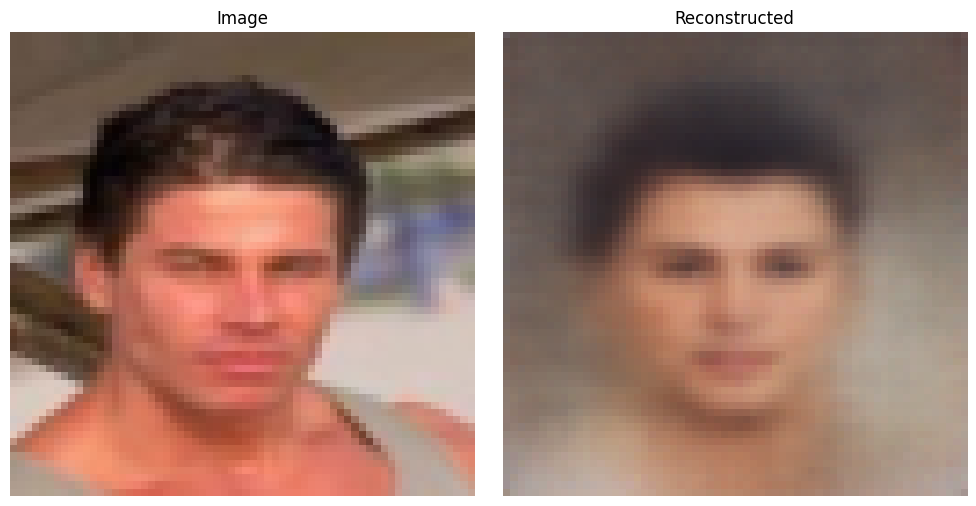

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.train_model(1, celeba_train_loader, 2) #m

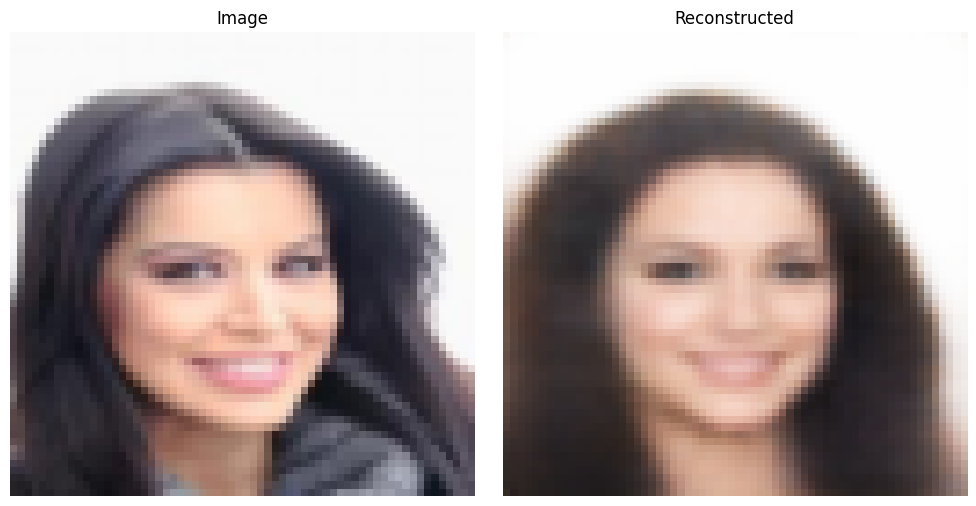

In [ ]:
images, labels = next(iter(celeba_train_loader))
images = images.to(device)
labels = labels.to(device)
rec = model.reconstruct(images)
model.plot_reconstruction(images[1], rec[1])

In [ ]:
model.classification_accuracy(celeba_train_loader)

0.9001663700372231

In [ ]:
model.classification_accuracy(celeba_test_loader)

0.895566531480887

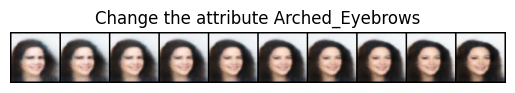

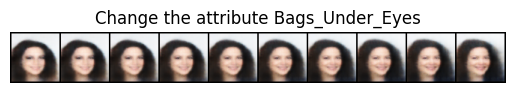

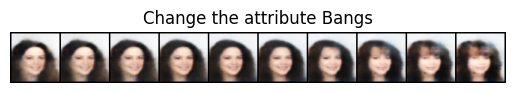

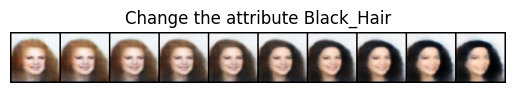

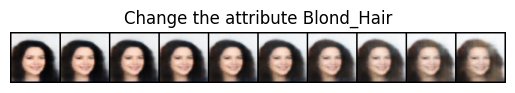

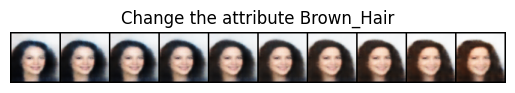

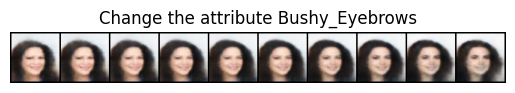

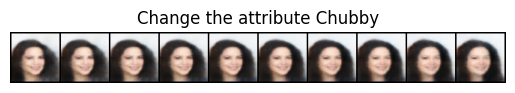

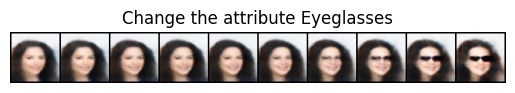

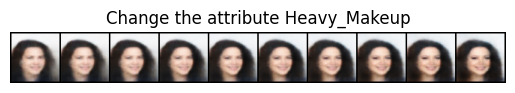

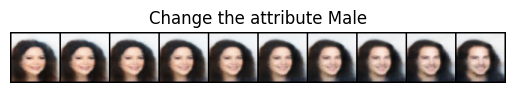

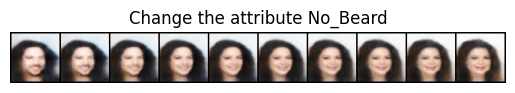

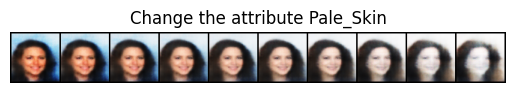

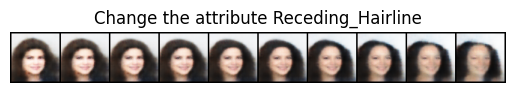

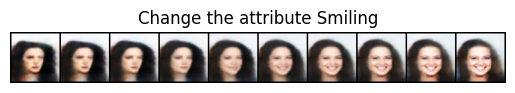

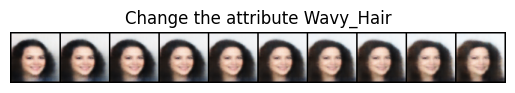

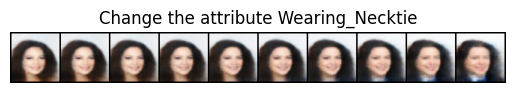

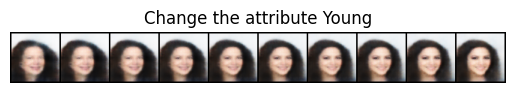

In [ ]:
model.latent_walk_all(images[1], mult=15)

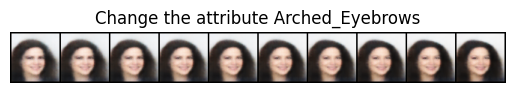

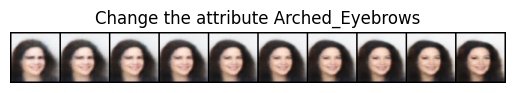

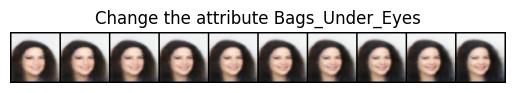

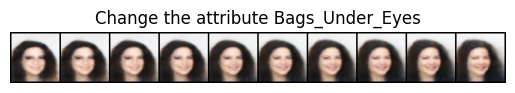

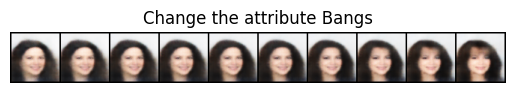

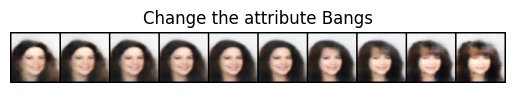

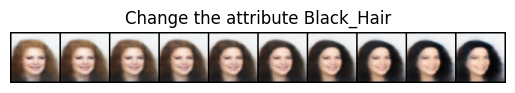

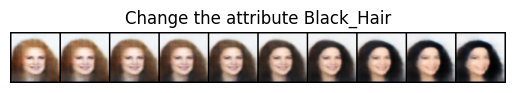

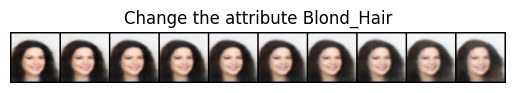

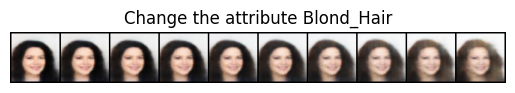

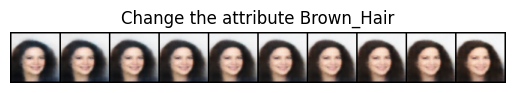

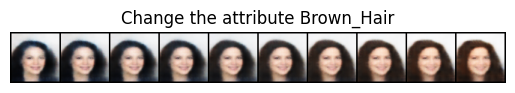

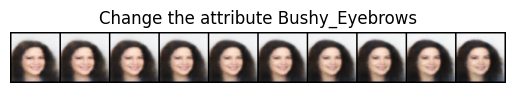

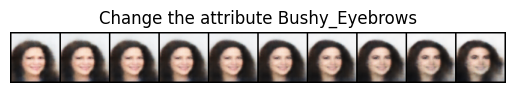

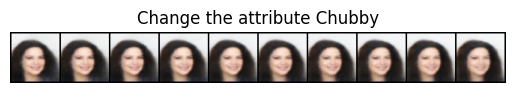

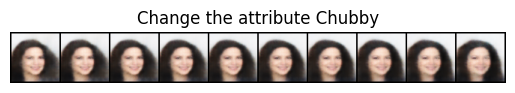

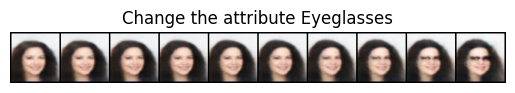

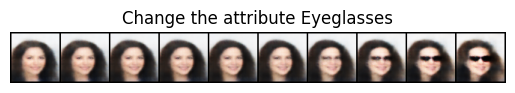

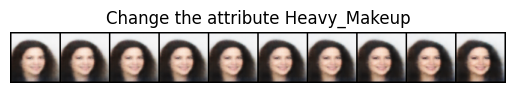

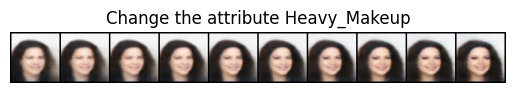

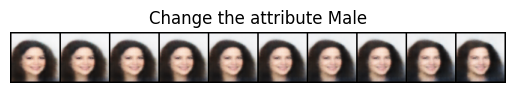

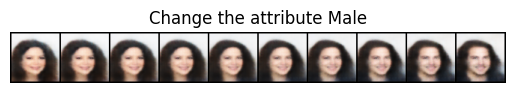

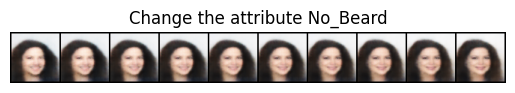

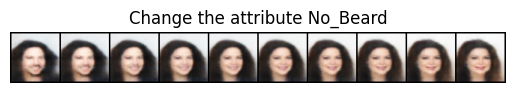

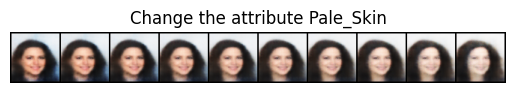

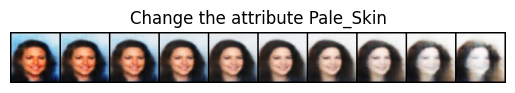

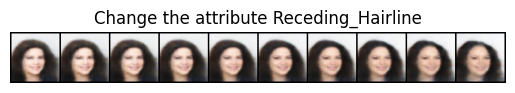

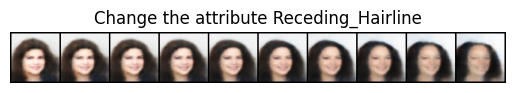

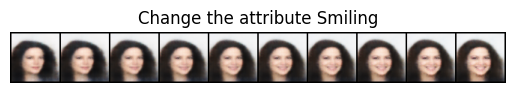

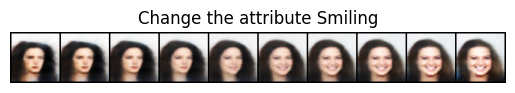

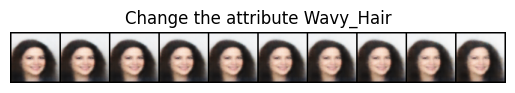

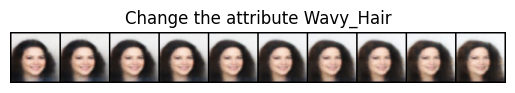

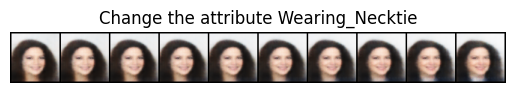

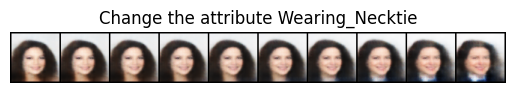

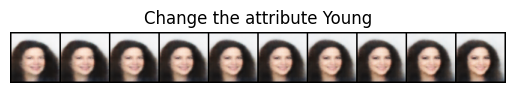

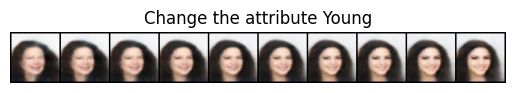

In [ ]:
model.latent_walk_ind(images[1], mult=15)

# Chest X-Ray Images (Pneumonia)

In [ ]:
style_dim = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_zc_per_label = np.ones(3)*2
model = CCVAE(style_dim=style_dim, n_zc_per_label=n_zc_per_label, device=device, task='chest', n_channels=1)

In [ ]:
model.load_weights()

Epoch: 1


41it [01:11,  1.75s/it]


Loss: 2384.7721751143295


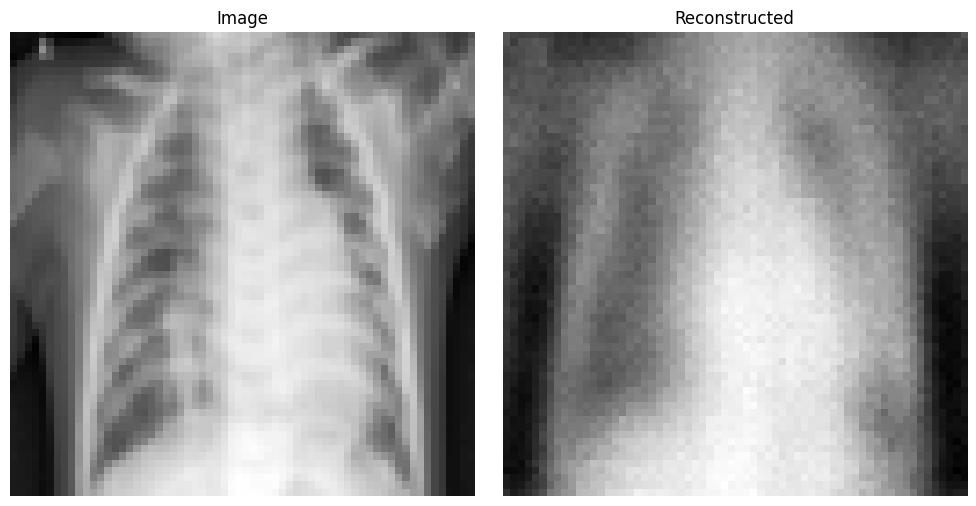

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.train_model(1, chest_train_loader, 2)

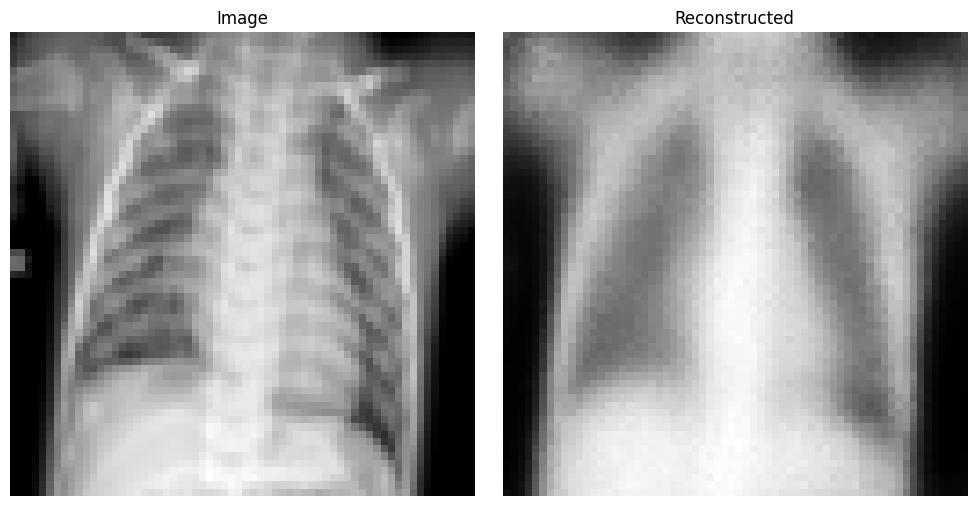

In [ ]:
images, labels = next(iter(chest_train_loader))
images = images.to(device)
labels = labels.to(device)
rec = model.reconstruct(images)
model.plot_reconstruction(images[21], rec[21])

In [ ]:
model.classification_accuracy(chest_train_loader)

0.9824271870822441

In [ ]:
model.classification_accuracy(chest_test_loader)

0.7761904835700989

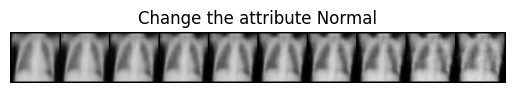

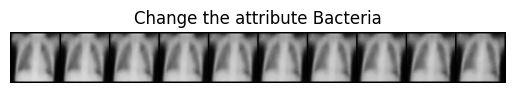

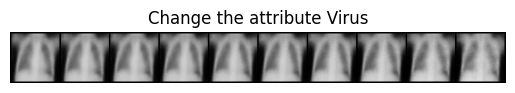

In [ ]:
model.latent_walk_all(images[21])

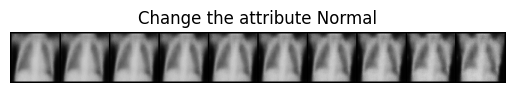

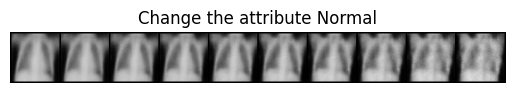

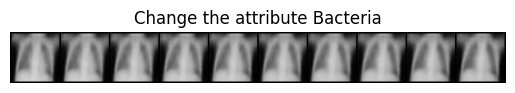

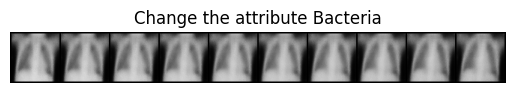

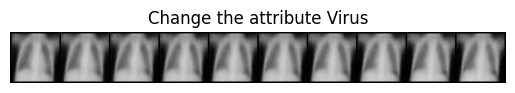

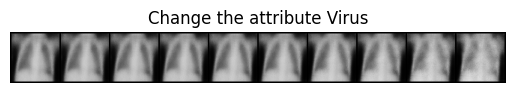

In [ ]:
model.latent_walk_ind(images[21])

# MNIST

In [ ]:
style_dim = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_zc_per_label = np.ones(10)*2
model = CCVAE(style_dim=style_dim, n_zc_per_label=n_zc_per_label, device=device, task='mnist', n_channels=1)

In [ ]:
model.load_weights()

Epoch: 1


469it [00:29, 15.91it/s]


Loss: 2288.7226213727677


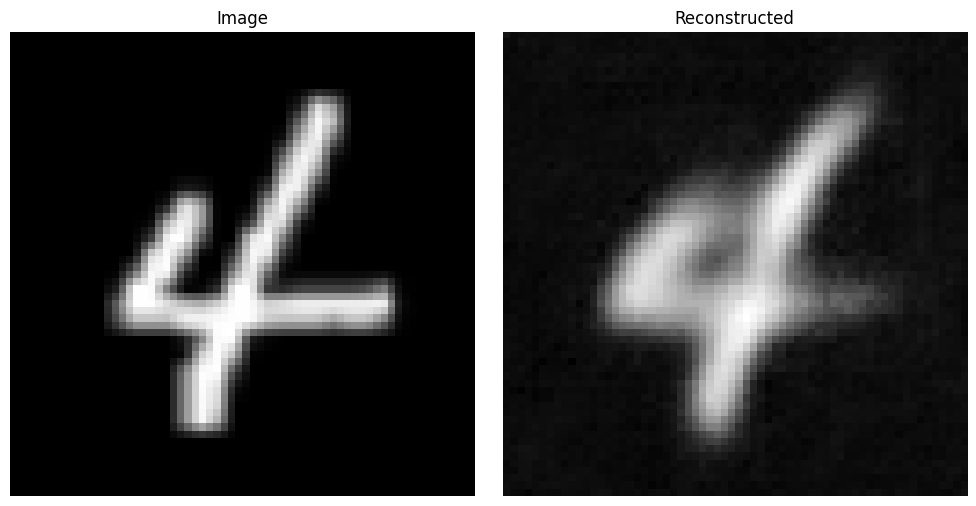

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.train_model(1, mnist_train_loader, 2)

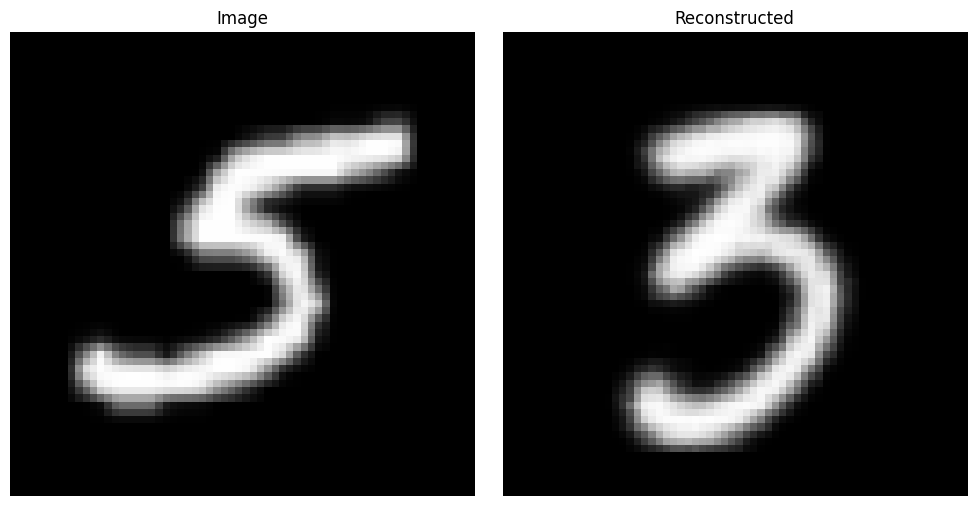

In [ ]:
images, labels = next(iter(mnist_train_loader))
images = images.to(device)
labels = labels.to(device)
rec = model.reconstruct(images)
model.plot_reconstruction(images[0], rec[1])

In [ ]:
model.classification_accuracy(mnist_train_loader)

0.9998717369047055

In [ ]:
model.classification_accuracy(mnist_test_loader)

0.9987341904941993

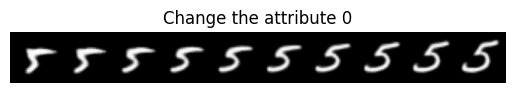

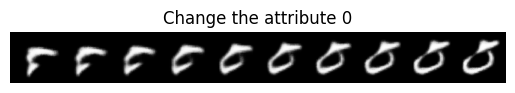

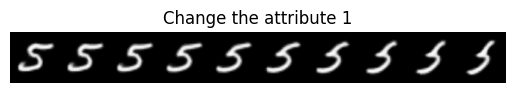

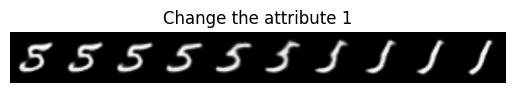

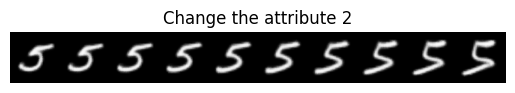

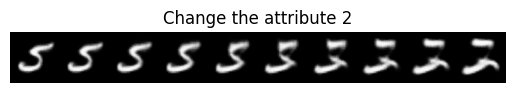

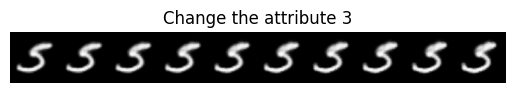

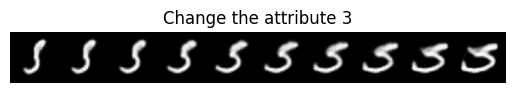

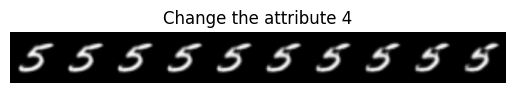

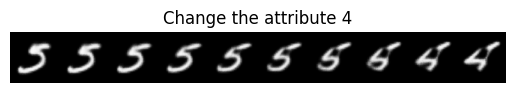

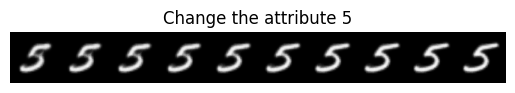

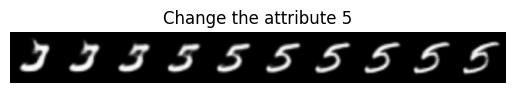

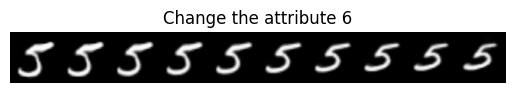

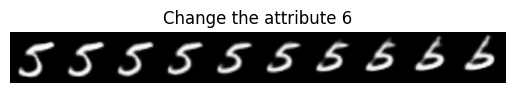

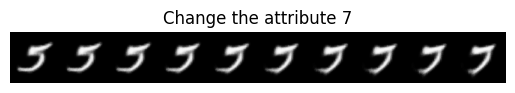

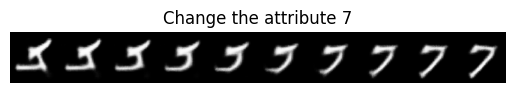

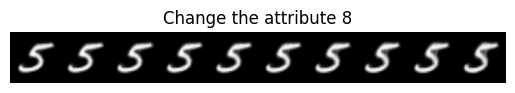

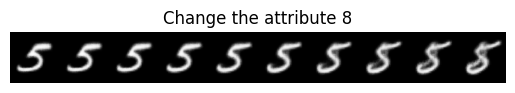

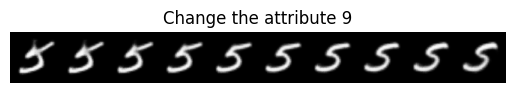

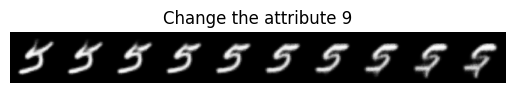

In [ ]:
model.latent_walk_ind(images[0])

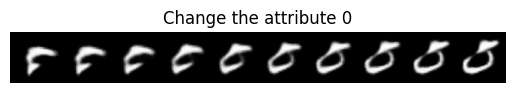

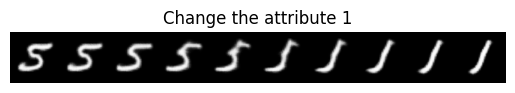

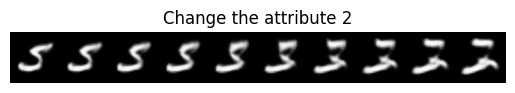

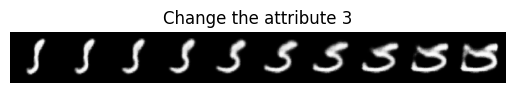

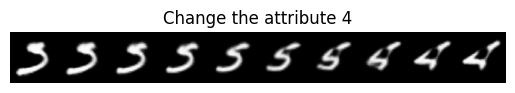

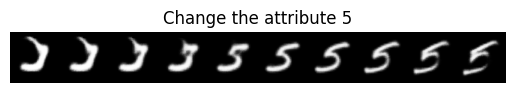

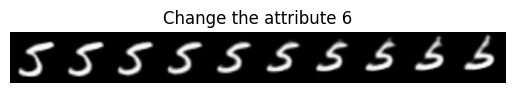

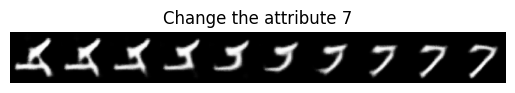

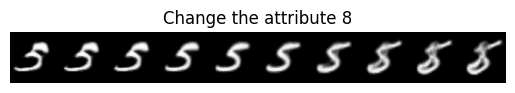

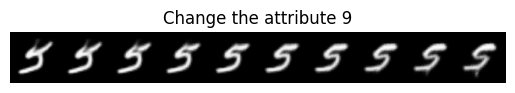

In [ ]:
model.latent_walk_all(images[0])